# Classificador de Cachorro

## Introdução

O objetivo deste artigo é criar um classificar capaz de diferir entre algumas raças de cachorro. A aplicação ficará disponível no HuggingFace Spaces para quem tiver interrese em testa-lá. Para a rede Neural nós iremos utilizar a resnet34 atráves da biblioteca do fastai, e para o nosso data set, foi utilizado uma base da imagens de Stanford, chamada de [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/), que entrega dados rotulados de 120 raças de cachorro. Também utilizaremos a biblioteca do duckduckgo_search para baixar algumas imagens para testar os resultados do modelo.

## Instalação de dependências

In [ ]:
!pip install fastai duckduckgo_search

## Criação do nosso DataBlock

Como já temos o conjunto de dados rotulado, não precisamos nós preocupar com essa parte, vamos direto para a criação do nosso DataBlock, ou melhor, DogBlock

Aqui em baixo nós temos o path onde estão todas as classes com as suas respectivas imagens para o treinamento do modelo

In [3]:
from fastai.vision.all import *
path = Path('/kaggle/input/dog-set/Images')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
dogBlock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

In [5]:
dls = dogBlock.dataloaders(path, bs=64)

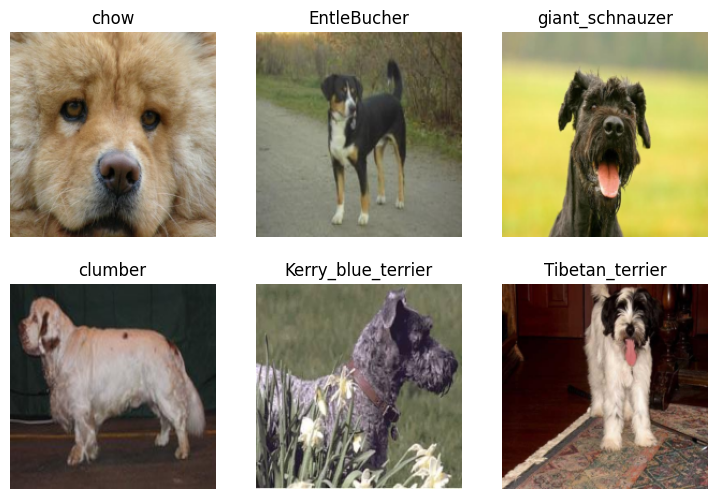

In [6]:
dls.show_batch(max_n=6)

## Treinamento do Modelo

Agora que nós temos nosso conjunto de dados e as definições de como ele será divido para o treinamento do modelo, vamos iniciar o treinamento!

Nós utilizaremos o vision_learner da biblioteca do fastai com a Rede Neural pré-treinada resnet34.

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 103MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.772326,0.995483,0.292031,03:31


epoch,train_loss,valid_loss,error_rate,time
0,1.148172,0.917775,0.275996,02:15
1,0.734035,0.806237,0.239553,02:17
2,0.272375,0.736884,0.217687,02:19


## Matrix de confusão

Como nós temos um conjunto de 120 classes, a matrix  de confusão ficou ilegível, por isso a ocultamos.

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

## Erros mais grotescos

Abaixo seguem alguns dos erros mais grotescos durante o treinamento do nosso modelo

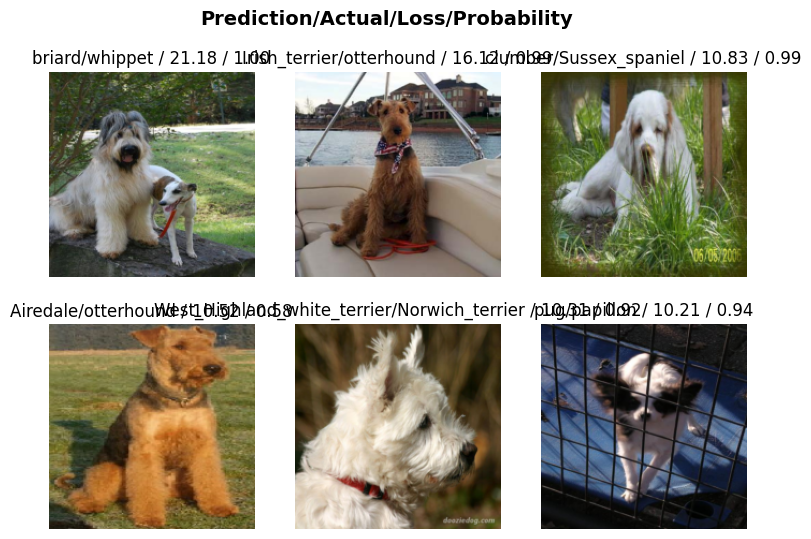

In [9]:
interp.plot_top_losses(6, nrows=2)

## Resultados do Modelo

Agora que o modelo já está treinado, vamos conferir alguns dos resultados que ele entregou.

Para isso vamos utilizar a função search_images(), que dado um termo, retorna um array com urls de imagens. E também, a função test(), que dado um termo imprime a raça prevista pelo modelo, e qual a probabilidade de ser ela.

In [10]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=500):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [11]:
from fastdownload import download_url
from fastai.vision.data import *

def test(term : str):
    download_url(search_images(f'{term}', max_images=1)[0], f'{term}.jpg', show_progress=False)
    dog, _, probs = learn.predict(PILImage.create(f'{term}.jpg'))
    max_prob_index = probs.argmax()  # Encontra o índice da classe com a maior probabilidade
    print(f'A raça prevista é: {dog}')
    print(f'Probabilidade: {probs[max_prob_index]:.4f}')

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


A raça prevista é: basset
Probabilidade: 0.9994


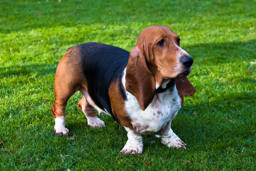

In [12]:
test('basset')
Image.open('basset.jpg').to_thumb(256,256)

A raça prevista é: Shih-Tzu
Probabilidade: 0.9657


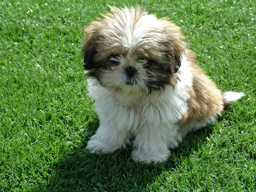

In [13]:
test('shih-tzu')
Image.open('shih-tzu.jpg').to_thumb(256,256)

A raça prevista é: Border_terrier
Probabilidade: 1.0000


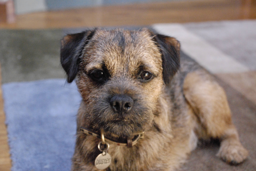

In [14]:
test('border-terrier')
Image.open('border-terrier.jpg').to_thumb(256,256)

A raça prevista é: golden_retriever
Probabilidade: 0.9991


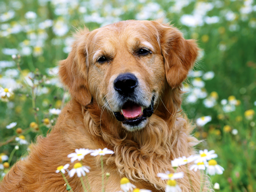

In [15]:
test('golden-retriever')
Image.open('golden-retriever.jpg').to_thumb(256,256)

A raça prevista é: silky_terrier
Probabilidade: 0.6961


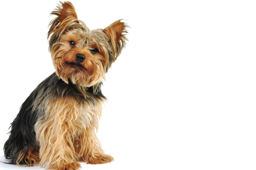

In [16]:
test('yorkshire')
Image.open('yorkshire.jpg').to_thumb(256,256)

## Exportação do Modelo

Agora que o módelo condiz com a proposta de crição dele, vamos fazer uma aplicação no Huggin Face, para isso nós precisamos  exporta-lo primeiro

In [33]:
learn.path = Path('.')
learn.export()

## Aplicação no Huggin Face

[Dogfier - Dog Classifier](https://huggingface.co/spaces/fastaioncampus/dogfier)